In [21]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vgg19

from utils import get_features, transformation_max, transformation_mean, get_weights, show

In [22]:
def show(images):
    fig, axes = plt.subplots(1, 4)
    for idx, img in enumerate(images):
        axes[idx].imshow(img, cmap="gray")

    fig.set_figwidth(110)
    fig.set_figheight(110)
    plt.show()
    
    
def get_weights(number_layers, style_weights):
    
    weights = []
    for layer in range(number_layers):
        w_number, value = style_weights[layer]
        w = [value for _ in range(w_number)]
        weights.extend(w)
    return weights

# Data Preprocessing

In [23]:
images_name = os.listdir('data/patches')
images = [Image.open(f"data/patches/{name}") for name in images_name]

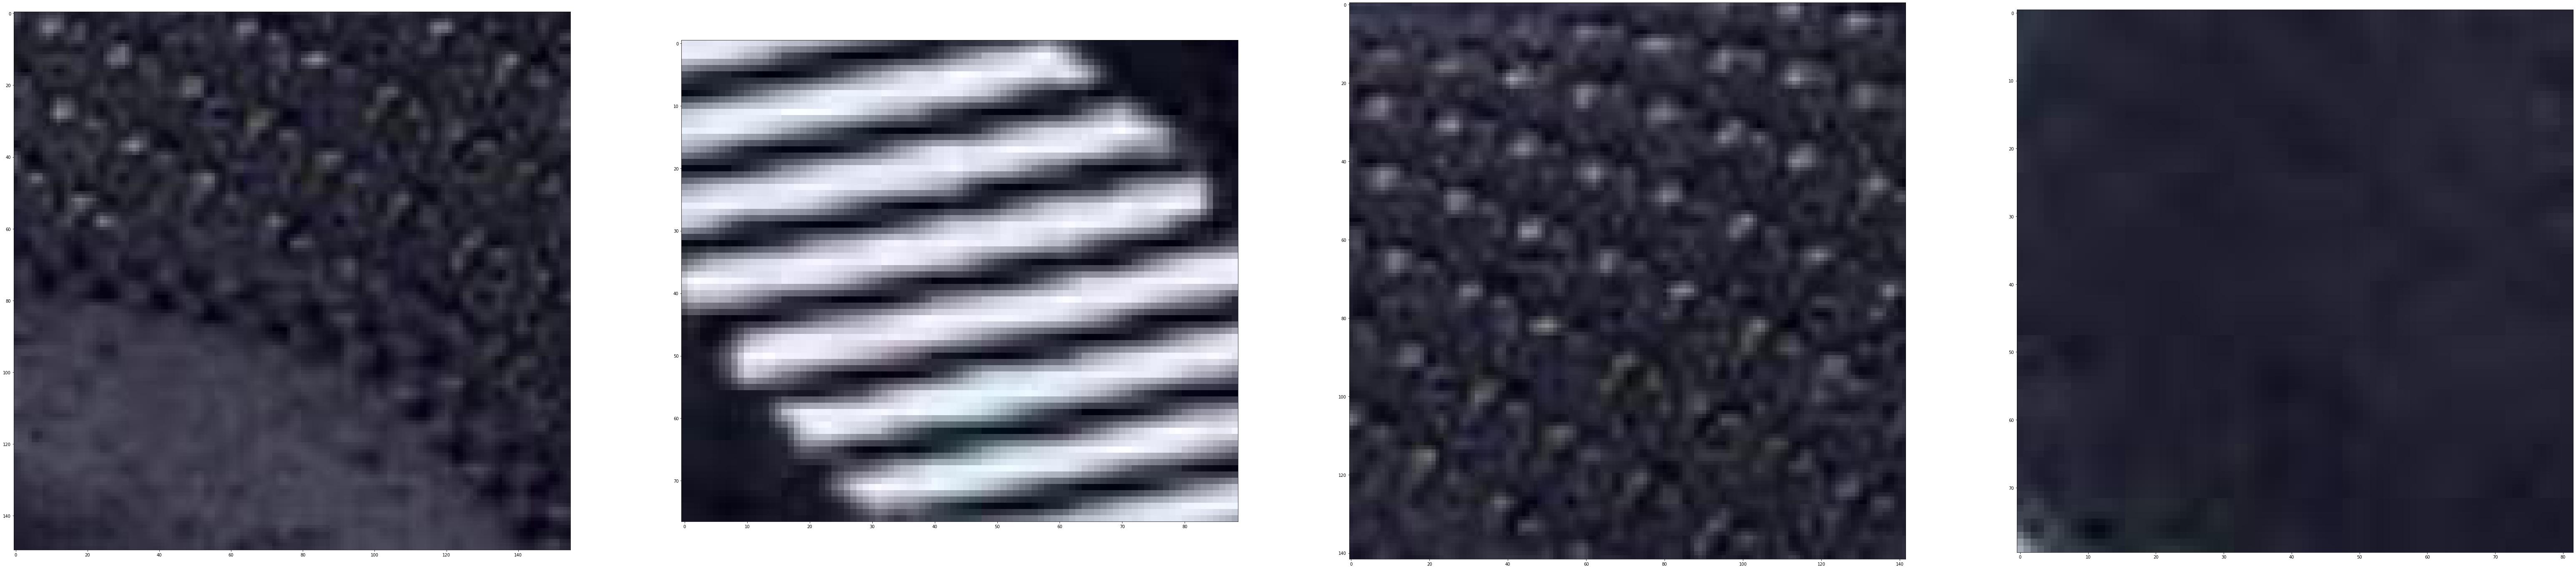

In [24]:
show(images)

In [25]:
SIZE = 500
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406), 
        (0.229, 0.224, 0.225)
    )
])

images_tensor = [transform(img).unsqueeze(0) for img in images]

# Model

In [26]:
vgg = vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)
    
    
vgg;

In [27]:
layers = {
    '0':  'conv1_1',
    '5':  'conv2_1', 
    '10': 'conv3_1', 
    '19': 'conv4_1',
    '28': 'conv5_1'
}

textures = [get_features(img, vgg, layers) for img in images_tensor]

# Layer weights

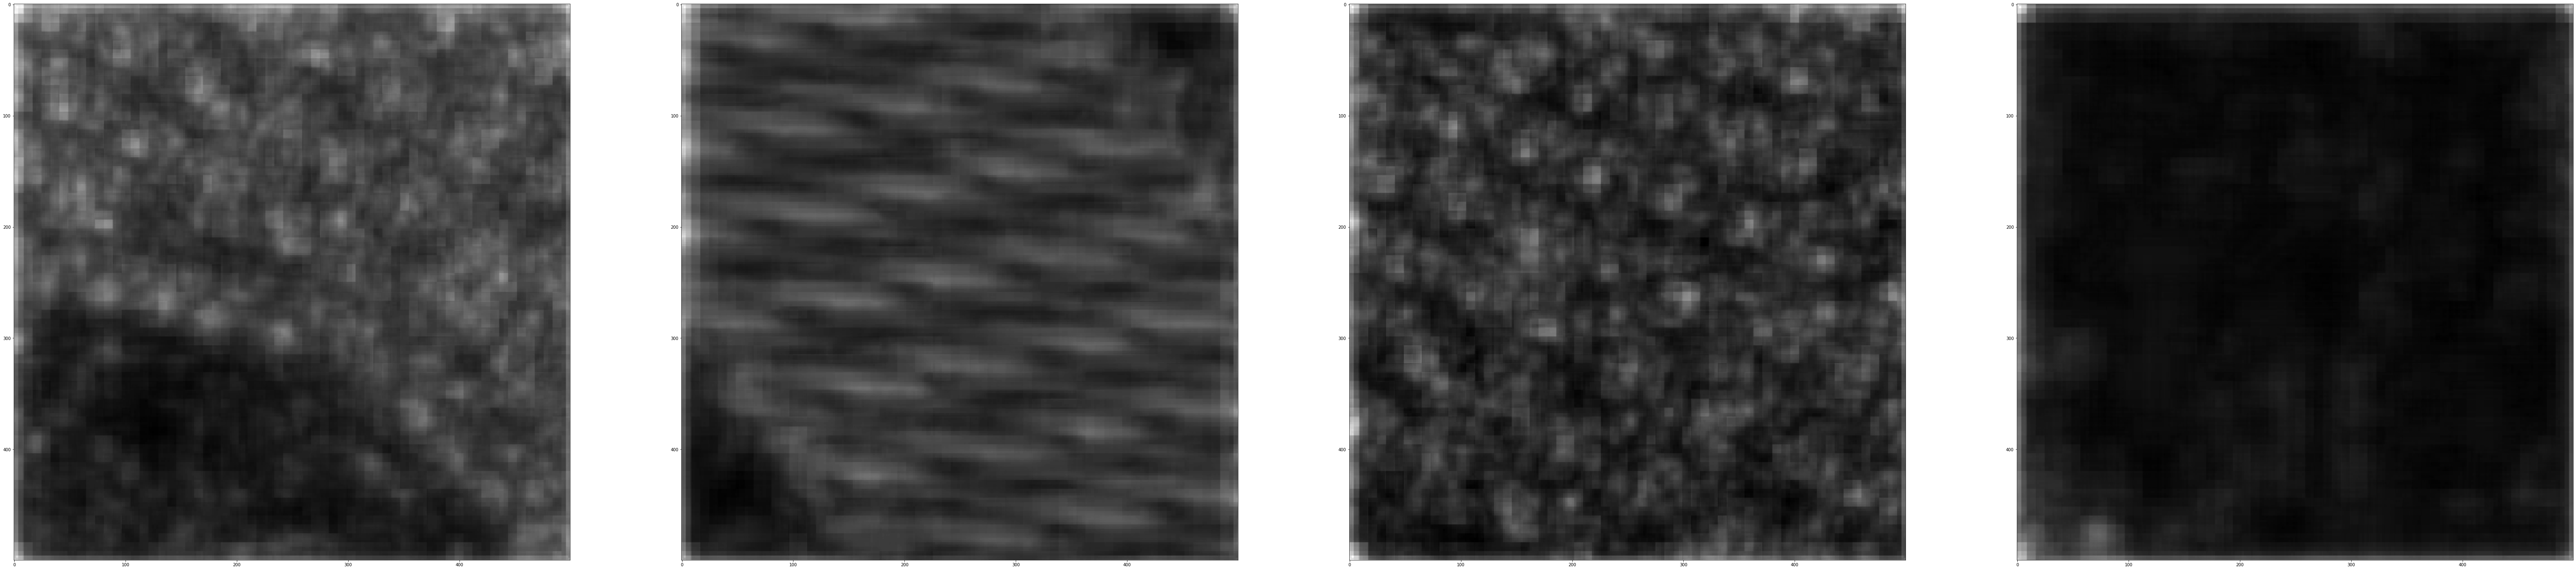

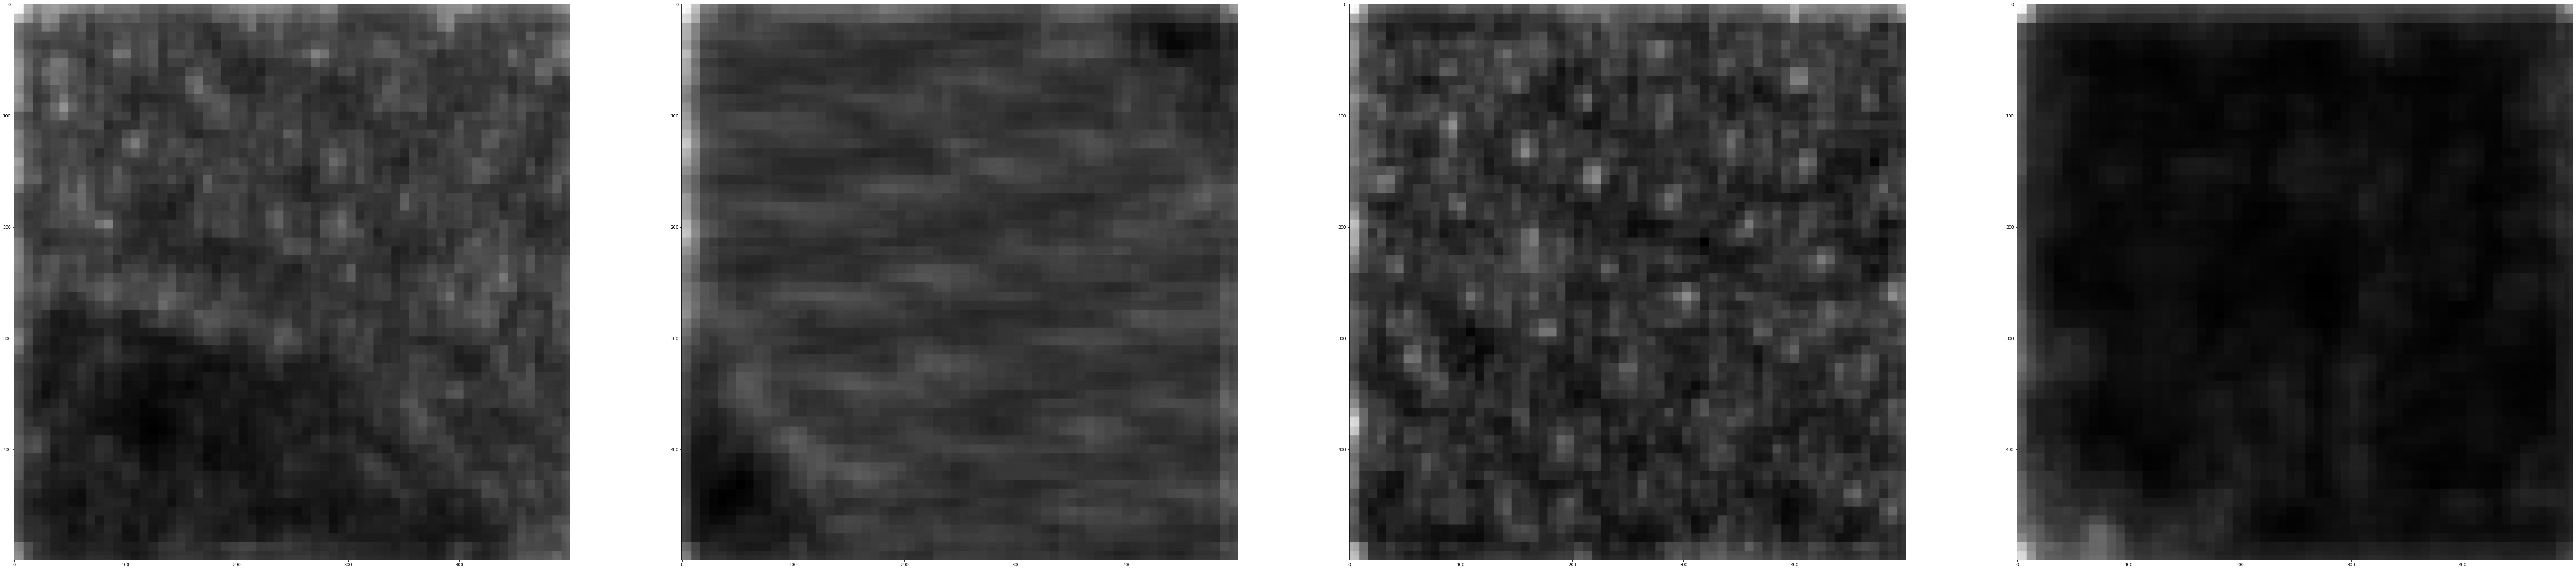

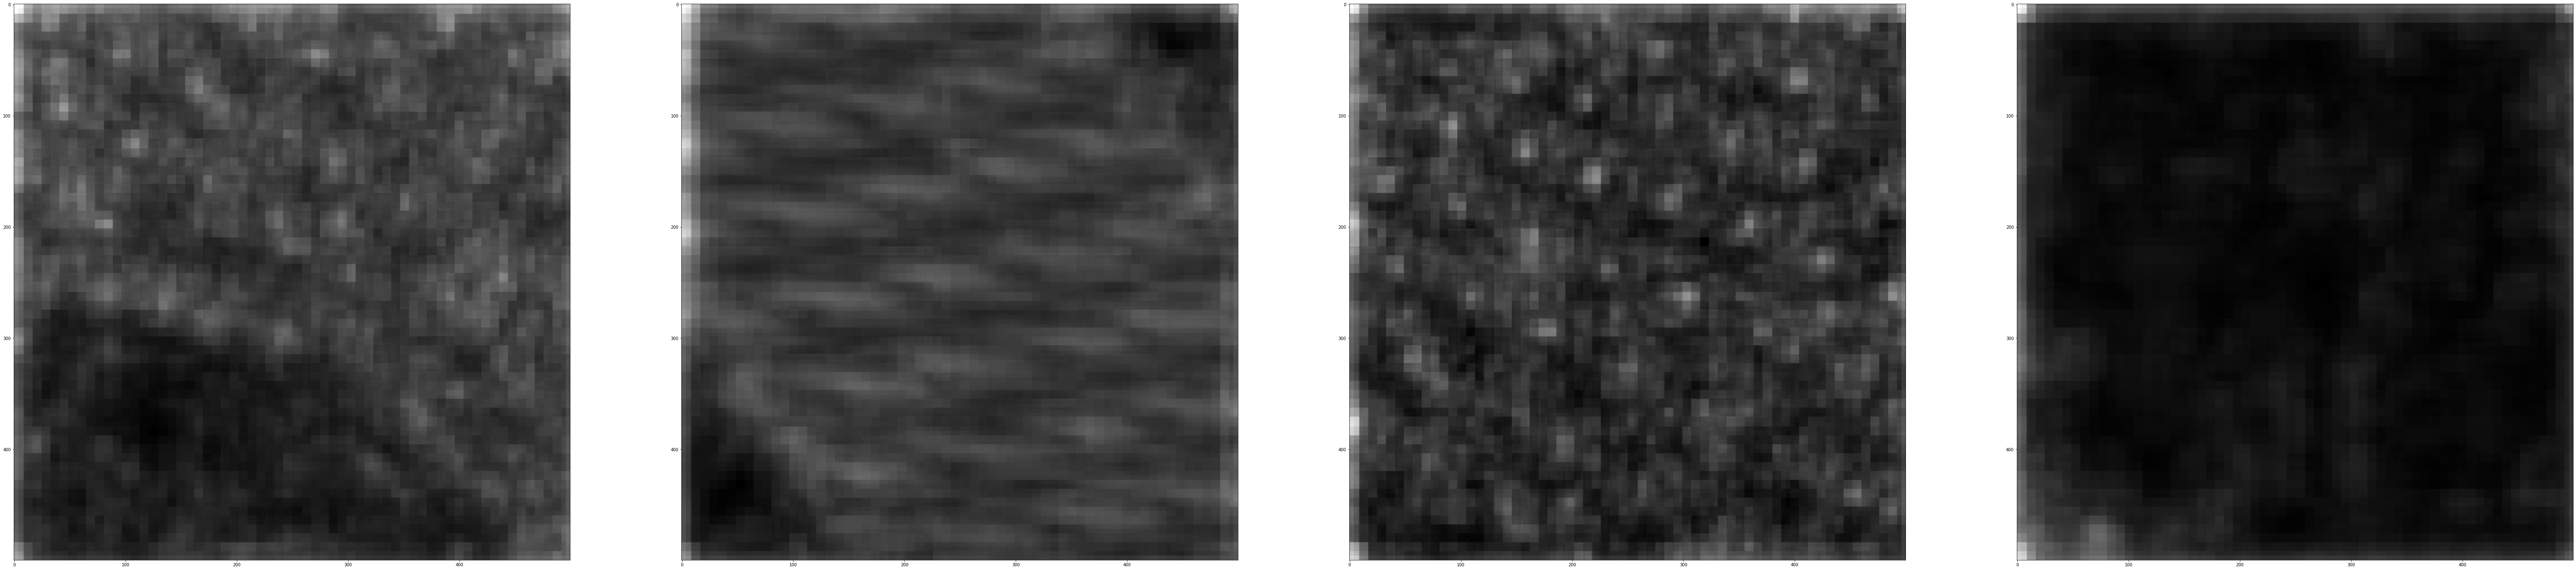

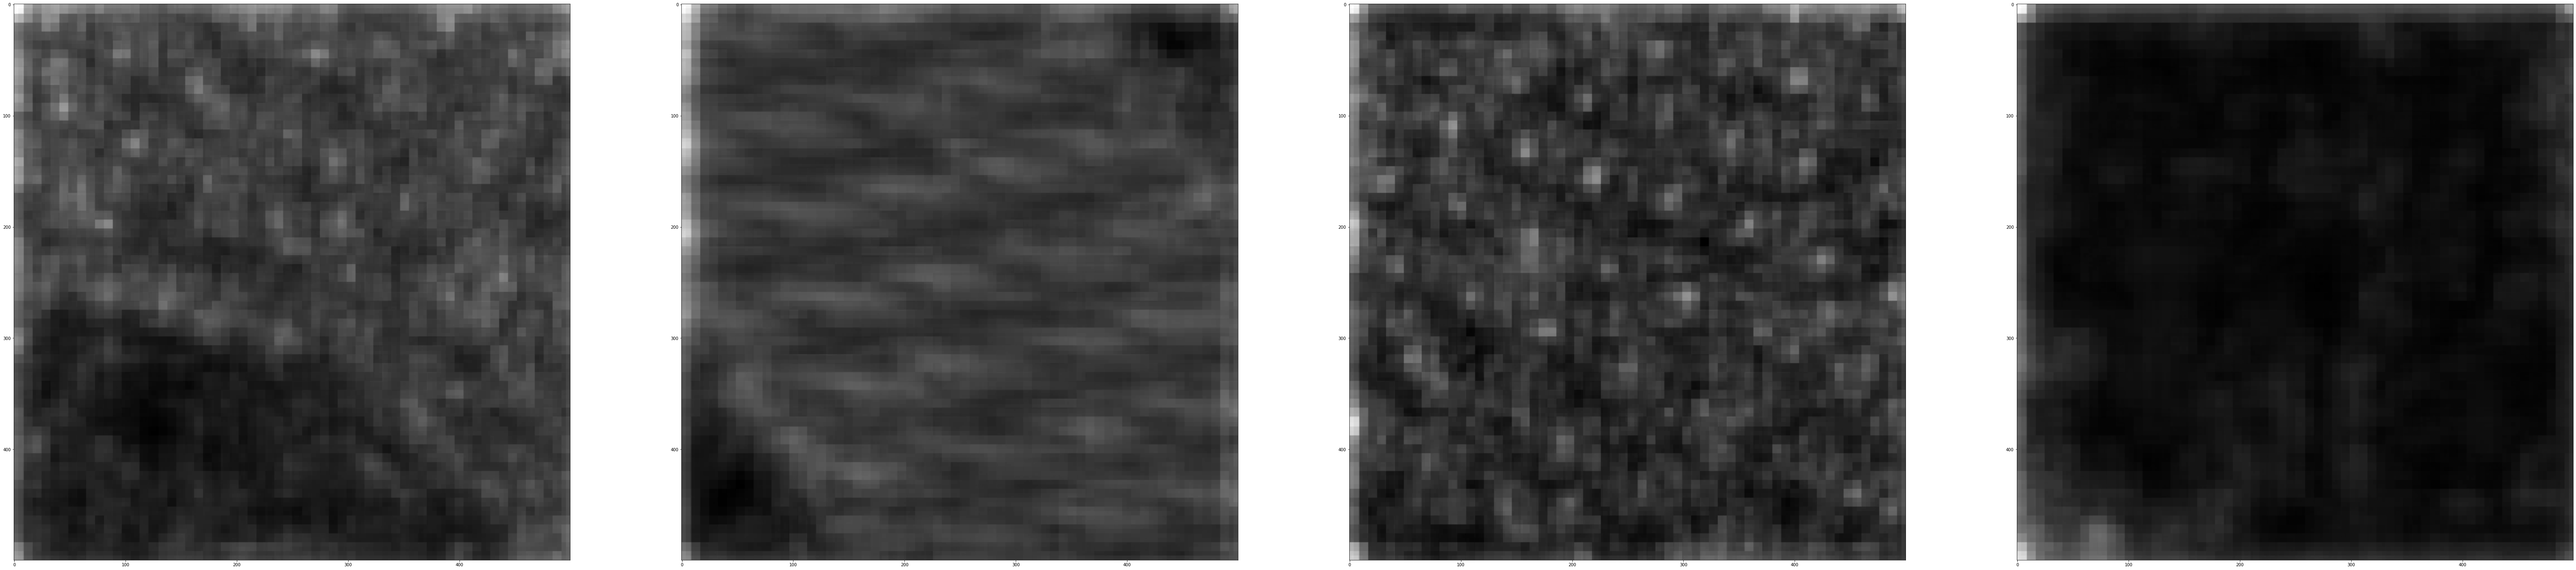

In [30]:
style_weights = {
    '1': [(64,  1.00), (128, 0.75), (256, 0.20), (512, 0.20), (512, 0.20)],
    '2': [(64,  0.20), (128, 0.20), (256, 0.20), (512, 0.75), (512, 1.00)],
    '3': [(64,  0.10), (128, 0.20), (256, 0.20), (512, 0.30), (512, 0.30)],
    '4': [(64,  0.10), (128, 0.10), (256, 0.20), (512, 0.40), (512, 0.40)],
}

for name, weights in style_weights.items():
    result = []
    for texture in textures:

        new_blocks = {}
        for idx, block in texture.items():

            scale_factor = SIZE / block.size()[-1]
            m = nn.Upsample(scale_factor=scale_factor, mode='nearest')    
            block_new = m(block)
            new_blocks[idx] = block_new

        all_blacks = torch.cat(tuple(new_blocks.values()), 1)
        result.append(transformation_mean(all_blacks, get_weights(5, weights)))
    show(result)

*It is likely that the texture is displayed best in the 2nd and 4th rows due to the setting of the weights*